# Bike-Sharing Dataset

The Bike-Sharing Dataset contains the bike rentals for almost every hour over the period 2011 and 2012. 
The dataset contains 14 features and we select the 11 features that are relevant to the prediction task. 
The features contain information about the day, like the month, the hour, the day of the week, the day-type,
and the weather conditions. 

Lets take a closer look!

In [1]:
import effector
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2023-12-19 13:33:56.611106: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 13:33:56.644102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 13:33:56.644124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 13:33:56.644931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 13:33:56.649814: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 13:33:56.650262: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Preprocess the data

In [2]:
# load dataset
df = pd.read_csv("./../data/Bike-Sharing-Dataset/hour.csv")

# drop columns
df = df.drop(["instant", "dteday", "casual", "registered", "atemp"], axis=1)

In [3]:
for col_name in df.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(df[col_name].unique()), df[col_name].mean(), df[col_name].std(), df[col_name].min(), df[col_name].max()))

Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: windspeed      , unique:   30, Mean:   0.19, Std:   0.12, Min:   0.00, 

Feature Table:

| Feature      | Description                            | Value Range                                         |
|--------------|----------------------------------------|-----------------------------------------------------|
| season       | season                                 | 1: winter, 2: spring, 3: summer, 4: fall            |
| yr           | year                                   | 0: 2011, 1: 2012                                    |
| mnth         | month                                  | 1 to 12                                             |
| hr           | hour                                   | 0 to 23                                             |
| holiday      | whether the day is a holiday or not    | 0: no, 1: yes                                       |
| weekday      | day of the week                        | 0: Sunday, 1: Monday, …, 6: Saturday                |
| workingday   | whether the day is a working day or not | 0: no, 1: yes                                      |
| weathersit   | weather situation                      | 1: clear, 2: mist, 3: light rain, 4: heavy rain     |
| temp         | temperature                            | normalized, [0.02, 1.00]                            |
| hum          | humidity                               | normalized, [0.00, 1.00]                            |
| windspeed    | wind speed                             | normalized, [0.00, 1.00]                            |


Target:

| Target       | Description                            | Value Range                                         |
|--------------|----------------------------------------|-----------------------------------------------------|
| cnt          | bike rentals per hour                  | [1, 977]                                            |


In [4]:
def preprocess(df):
    # shuffle
    df.sample(frac=1).reset_index(drop=True)

    # Standarize X
    X_df = df.drop(["cnt"], axis=1)
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = df["cnt"]
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(df)

In [5]:
def split(X_df, Y_df):
    # data split
    X_train = X_df[:int(0.8 * len(X_df))]
    Y_train = Y_df[:int(0.8 * len(Y_df))]
    X_test = X_df[int(0.8 * len(X_df)):]
    Y_test = Y_df[int(0.8 * len(Y_df)):]
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)

## Fit a Neural Network

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a mean absolute error on the test of about \(38\) counts.

In [6]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20


2023-12-19 13:33:58.184866: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


28/28 [==============================] - 1s 12ms/step - loss: 0.4592 - mae: 0.4937 - root_mean_squared_error: 0.6776
Epoch 2/20
28/28 [==============================] - 0s 11ms/step - loss: 0.3112 - mae: 0.3991 - root_mean_squared_error: 0.5578
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.2446 - mae: 0.3479 - root_mean_squared_error: 0.4945
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1981 - mae: 0.3144 - root_mean_squared_error: 0.4451
Epoch 5/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1475 - mae: 0.2691 - root_mean_squared_error: 0.3841
Epoch 6/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1037 - mae: 0.2207 - root_mean_squared_error: 0.3220
Epoch 7/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0768 - mae: 0.1919 - root_mean_squared_error: 0.2772
Epoch 8/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0646 - mae: 0.1746 - root_mean_squared_e

[0.23217250406742096, 0.3299064636230469, 0.4818428158760071]

## Explain

In [7]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()


In [8]:
scale_x = {"mean": x_mean[3], "std": x_std[3]}
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean[i], "std": x_std[i]} for i in range(len(x_mean))]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


## Global Effect

### PDP 

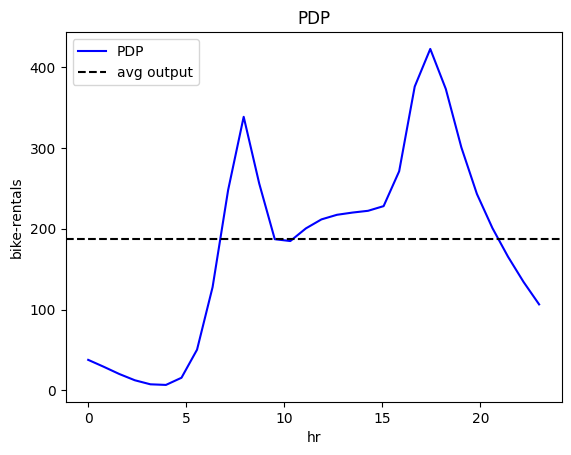

In [9]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
pdp.plot(feature=3, centering=False, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

2023-12-19 13:34:07.190214: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2048000000 exceeds 10% of free system memory.
2023-12-19 13:34:07.538920: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2048000000 exceeds 10% of free system memory.
2023-12-19 13:34:07.811640: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2048000000 exceeds 10% of free system memory.


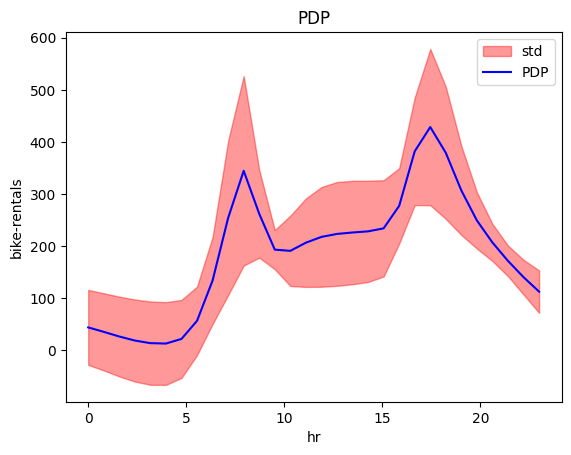

In [10]:
pdp.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y)

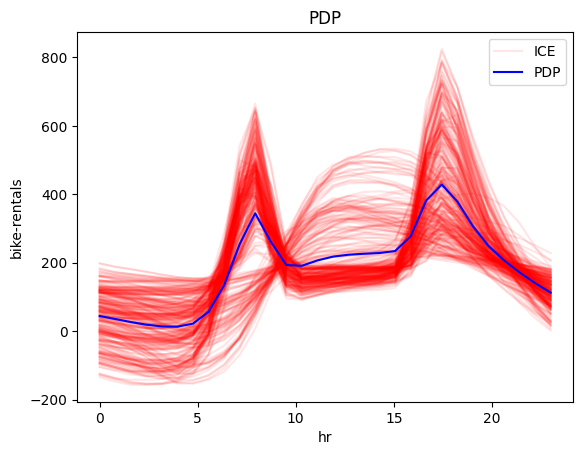

In [11]:
pdp.plot(feature=3, heterogeneity="ice", centering=True, scale_x=scale_x, scale_y=scale_y, nof_ice=300)

### RHALE

Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in divide


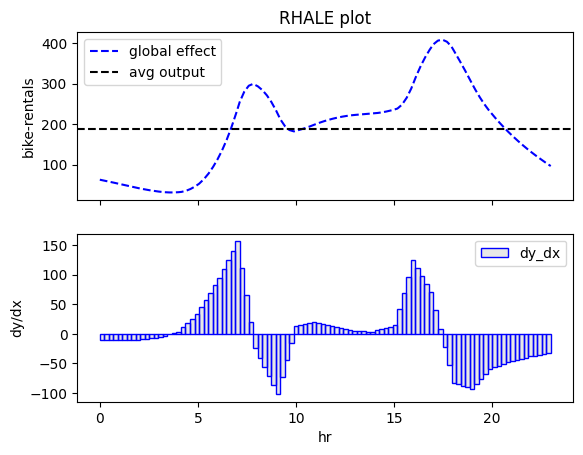

In [12]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
binning_method = effector.binning_methods.Greedy(init_nof_bins=1000, min_points_per_bin=100, discount=0, cat_limit=10)
rhale.fit(features=3, binning_method=binning_method)
rhale.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

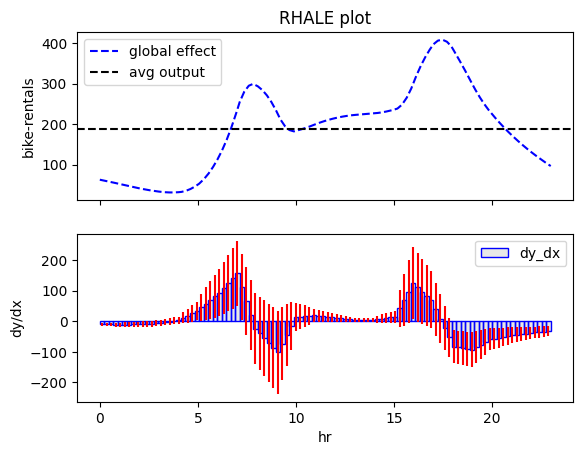

In [13]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
binning_method = effector.binning_methods.Greedy(init_nof_bins=100, min_points_per_bin=100, discount=0, cat_limit=10)
rhale.fit(features=3, binning_method=binning_method)
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

# Regional Effects

### RegionalRHALE

In [14]:
# Regional RHALE
regional_rhale = effector.RegionalRHALE(
    data=X_train.to_numpy(),
    model=model_forward,
    model_jac=model_jac,
    cat_limit=10,
    feature_names=feature_names,
)

regional_rhale.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    binning_method="greedy",
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.91s/it]


In [15]:
regional_rhale.describe_subregions(features=3, only_important=True, scale_x=scale_x_list)

Important splits for feature hr
- On feature workingday (cat)
  - Range: [0.00, 1.00]
  - Candidate split positions: 0.00, 1.00
  - Position of split: 0.00
  - Heterogeneity before split: 5.69
  - Heterogeneity after split: 3.76
  - Heterogeneity drop: 1.93 (51.24 %)
  - Number of instances before split: 13903
  - Number of instances after split: [4387, 9516]
- On feature temp (cont)
  - Range: [0.02, 1.00]
  - Candidate split positions: 0.12, 0.31, 0.51, 0.71, 0.90
  - Position of split: 0.51
  - Heterogeneity before split: 3.76
  - Heterogeneity after split: 3.14
  - Heterogeneity drop: 0.62 (19.74 %)
  - Number of instances before split: [4387, 9516]
  - Number of instances after split: [2390, 1997, 4610, 4906]


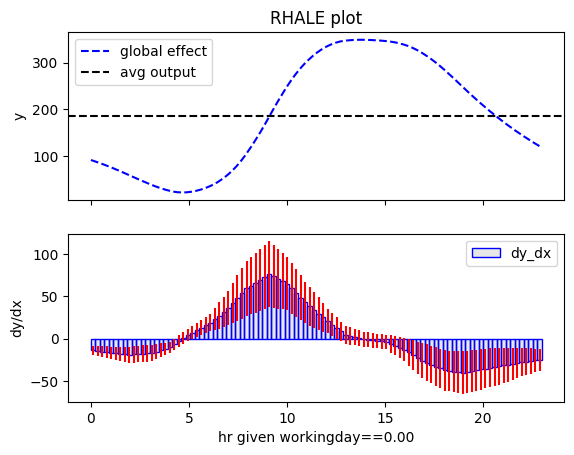

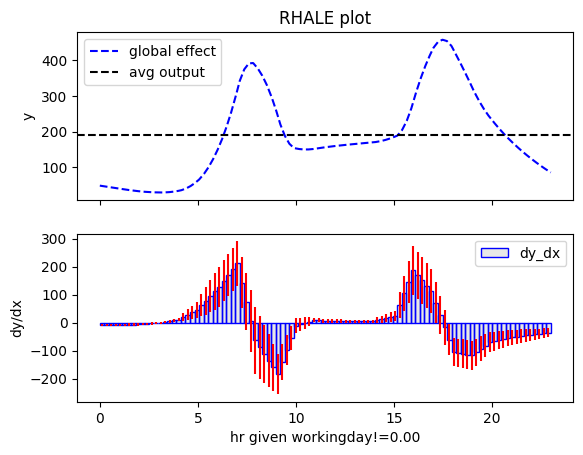

In [16]:
regional_rhale.plot_first_level(feature=3, heterogeneity=True, centering=True, scale_x_per_feature=scale_x_list, scale_y=scale_y, show_avg_output=True)


### RegionalPDP

In [17]:
regional_pdp = effector.RegionalPDP(
    data=X_train.to_numpy(),
    model=model_forward,
    cat_limit=10,
    feature_names=feature_names,
)

regional_pdp.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.56s/it]


In [18]:
regional_pdp.describe_subregions(features=3, only_important=True, scale_x=scale_x_list)

Important splits for feature hr
- On feature workingday (cat)
  - Range: [0.00, 1.00]
  - Candidate split positions: 0.00, 1.00
  - Position of split: 1.00
  - Heterogeneity before split: 0.59
  - Heterogeneity after split: 0.45
  - Heterogeneity drop: 0.14 (30.52 %)
  - Number of instances before split: 13903
  - Number of instances after split: [9516, 4387]
- On feature temp (cont)
  - Range: [0.02, 1.00]
  - Candidate split positions: 0.12, 0.31, 0.51, 0.71, 0.90
  - Position of split: 0.51
  - Heterogeneity before split: 0.41
  - Heterogeneity after split: 0.36
  - Heterogeneity drop: 0.05 (13.49 %)
  - Number of instances before split: [9516, 4387]
  - Number of instances after split: [4610, 4906, 2390, 1997]


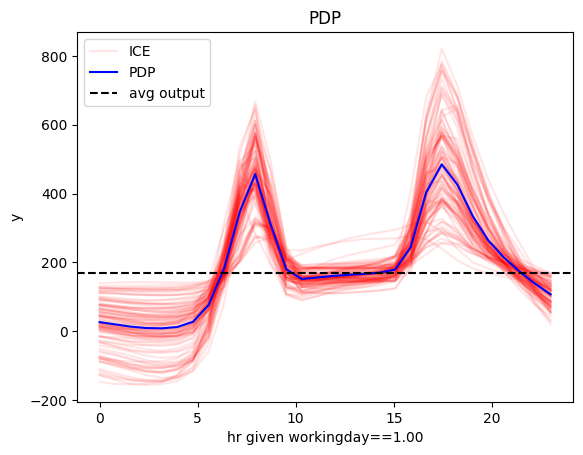

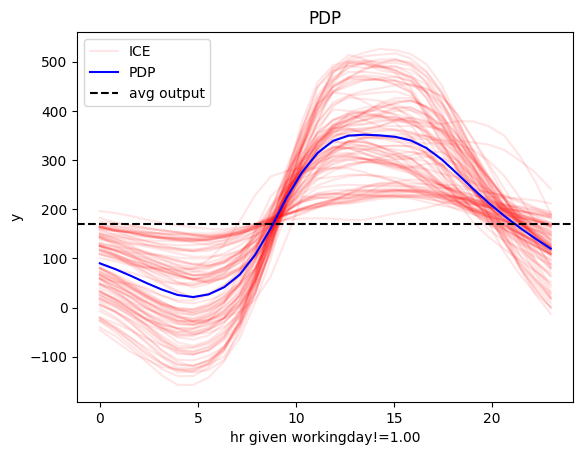

In [19]:

regional_pdp.plot_first_level(feature=3, heterogeneity=True, centering=True, scale_x_per_feature=scale_x_list, scale_y=scale_y, show_avg_output=True)
